# Example 02. Generate a single scan PAVD profile

This example generates a single scan Plant Area Volume Density (PAVD) profile using Jupp et al. (2009).
The robust plane fitting approach of Calders et al. (2014) is used for defining the ground elevation and height above ground for all points.

## Load all the required modules

In [1]:
import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator

from pylidar_tls_canopy import riegl_io, plant_profile, grid

In [2]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Some plotting functions

In [3]:
def plot_ground_plane(x, y, z, grid_extent, grid_resolution, planefit, 
                      grid_origin=[0,0], figsize=[8,8], elev=None, azim=None):
    """Example function to plot a ground plane"""    
    xv = np.linspace(grid_origin[0]-grid_extent/2, grid_origin[0]+grid_extent/2, grid_extent//grid_resolution + 1)
    yv = np.linspace(grid_origin[1]-grid_extent/2, grid_origin[1]+grid_extent/2, grid_extent//grid_resolution + 1)
    xc,yc = np.meshgrid(xv,yv)
    zc = planefit['Parameters'][1] * xc + planefit['Parameters'][2] * yc + planefit['Parameters'][0]    
    fig = plt.figure(figsize=figsize)
    with plt.style.context('seaborn-talk'):
        ax = fig.add_subplot(projection='3d')
        ax.set_box_aspect([np.ptp(x), np.ptp(y), np.ptp(z)])
        ax.plot_wireframe(xc, yc, zc)
        ax.scatter(x, y, z, color='Brown')
        ax.set(xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)')
        ax.set(title=f'Extent = {grid_extent}m | Resolution = {grid_resolution}m')  
        ax.view_init(elev, azim)
    fig.tight_layout()
    plt.show()
    
    
def plot_vertical_profiles(profiles, height, labels=['Hinge','Linear','Weighted'], title=None,
                          figsize=[6,6], ylim=(0,50), xlim=None, xlabel=r'PAVD ($m^2 m^{-3}$)'):
    """Example function to plot a vertical profile"""
    fig, ax = plt.subplots(figsize=figsize, squeeze=True)
    with plt.style.context('seaborn-talk'):
        for i,profile in enumerate(profiles):
            if labels is None:
                ax.plot(profile, height, linewidth=1.5)
            else:
                ax.plot(profile, height, label=labels[i], linewidth=1.5)
        ax.set(xlabel=xlabel, ylabel='Height (m)')
        ax.set(ylim=ylim, xlim=xlim, title=title)
        ax.set_facecolor('white')
        if labels is not None:
            ax.legend()
    fig.tight_layout() 
    plt.show()

    
def plot_riegl_grid(data, label='Range (m)', clim=[0,30], figsize=(16,10), nbins=10,
                    cmap='bone', nreturns=None, extend='max', nodata=-9999, extent=None,
                    xlabel=None, ylabel=None, facecolor='white'):
    """Example function to plot a RIEGL grid"""
    if nreturns is None:
        nreturns = data.shape[0]
    fig, ax = plt.subplots(ncols=1, nrows=nreturns, squeeze=False, 
                           sharex=True, sharey=True, figsize=figsize)
    with plt.style.context('seaborn-notebook'):
        for i in range(nreturns):
            ax[i,0].set_facecolor(facecolor)
            ax[i,0].set(adjustable='box', aspect='equal')
            ax[i,0].set(xlabel=xlabel, ylabel=ylabel)
            if extent is None:
                ax[i,0].get_xaxis().set_visible(False)
                ax[i,0].get_yaxis().set_visible(False)
            tmp = np.ma.masked_equal(data[i], nodata)
            p = ax[i,0].imshow(tmp, interpolation='nearest', clim=clim, 
                               cmap=matplotlib.cm.get_cmap(cmap,nbins),  
                               vmin=clim[0], vmax=clim[1], extent=extent)
            divider = make_axes_locatable(ax[i,0])
            cax = divider.append_axes('right', size='2%', pad=0.05)
            cbar = fig.colorbar(p, label=label, cax=cax, extend=extend)
            cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=nbins))
    fig.tight_layout()
    plt.show()

## Identify all of the input files

We need both the RDBX and RXP files for the VZ400i and later scanner models. The RDBX have the point cloud corrected with RIEGL MTA processing, and the RXP files have all the pulse information for shots with not returns, allowing us to separate the absence of a return from the absence of a measurement.

If you are using a RIEGL VZ400 scanner or used a pulse rate <= 300khz, then you only need the RXP files to generate vertical profiles.

In [4]:
# Amazon example
os.chdir('/gpfs/data1/vclgp/data/tls_point_clouds/riegl_registered/maeda_Amazon_Dimona-100ha-SOUTH.RiSCAN')

# Upright scan files
upright_rxp_fn = 'SCANS/ScanPos001/SINGLESCANS/190426_112319.rxp'
upright_rdbx_fn = 'project.rdb/SCANS/ScanPos001/SINGLESCANS/190426_112319/190426_112319.rdbx'
upright_transform_fn = 'project.rdb/SCANS/ScanPos001.DAT'

# Tilt scan files
tilt_rxp_fn = 'SCANS/ScanPos002/SINGLESCANS/190426_112552.rxp'
tilt_rdbx_fn = 'project.rdb/SCANS/ScanPos002/SINGLESCANS/190426_112552/190426_112552.rdbx'
tilt_transform_fn = 'project.rdb/SCANS/ScanPos002.DAT'

In [5]:
# NEON-SERC example
os.chdir('/gpfs/data1/vclgp/data/tls_point_clouds/riegl_registered/neon_serc_220305_024625.RiSCAN')

# Upright scan files
upright_rxp_fn = 'SCANS/ScanPos001/SINGLESCANS/220305_032127.rxp'
upright_rdbx_fn = 'project.rdb/SCANS/ScanPos001/SINGLESCANS/220305_032127/220305_032127.rdbx'
upright_transform_fn = 'project.rdb/SCANS/ScanPos001.DAT'

# Tilt scan files
tilt_rxp_fn = 'SCANS/ScanPos002/SINGLESCANS/220305_032954.rxp'
tilt_rdbx_fn = 'project.rdb/SCANS/ScanPos002/SINGLESCANS/220305_032954/220305_032954.rdbx'
tilt_transform_fn = 'project.rdb/SCANS/ScanPos002.DAT'

## Fit and check the ground plane

Single scans often do not have an unobstructed view of the ground, therefore we have to make some simplifying assumptions when estimating the ground elevation. Here we follow the robust plane fitting method of Calders et al. (2014) using both the upright and tilt scans as input.

In [6]:
# Determine the origin coordinates to use
transform_matrix = riegl_io.read_transform_file(upright_transform_fn)
x0,y0,z0,_ = transform_matrix[3,:]

In [7]:
grid_extent = 60
grid_resolution = 10
grid_origin = [x0,y0]

# If using RXP files only as input, set rxp to True:
x,y,z,r = plant_profile.get_min_z_grid([upright_rdbx_fn,tilt_rdbx_fn], 
                                       [upright_transform_fn,tilt_transform_fn], 
                                       grid_extent, grid_resolution, grid_origin=grid_origin,
                                       rxp=False)

In [8]:
# Optional weighting of points by 1 / range
planefit = plant_profile.plane_fit_hubers(x, y, z, w=1/r)
planefit['Summary']

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      Z   No. Observations:                   49
Model:                            RLM   Df Residuals:                       46
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 14 Apr 2023                                         
Time:                        00:01:58                                         
No. Iterations:                    27                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.3253      0.030   -245.547      0.000      -7.384      -7.267
X             -0.0012      0.004     -0.310      0.756      -0.009       0.006
Y              0.0754      0.004     19.507      0.000       0.068       0.083
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

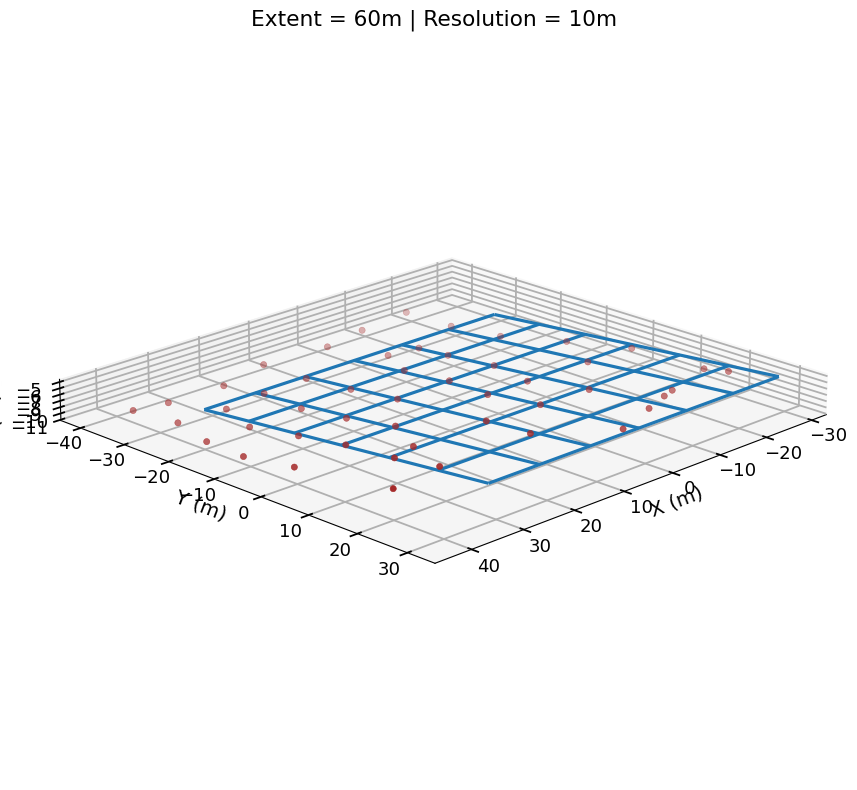

In [9]:
plot_ground_plane(x, y, z, grid_extent, grid_resolution, planefit, grid_origin=grid_origin, elev=20, azim=45)

In [10]:
height_grid = grid.grid_rdbx_cartesian([upright_rdbx_fn,tilt_rdbx_fn], [upright_transform_fn,tilt_transform_fn], 
                                       0.1, planefit=planefit, extent=[grid_extent,grid_extent], method='MAX',
                                       ulc=[x0-grid_extent/2,y0+grid_extent/2])

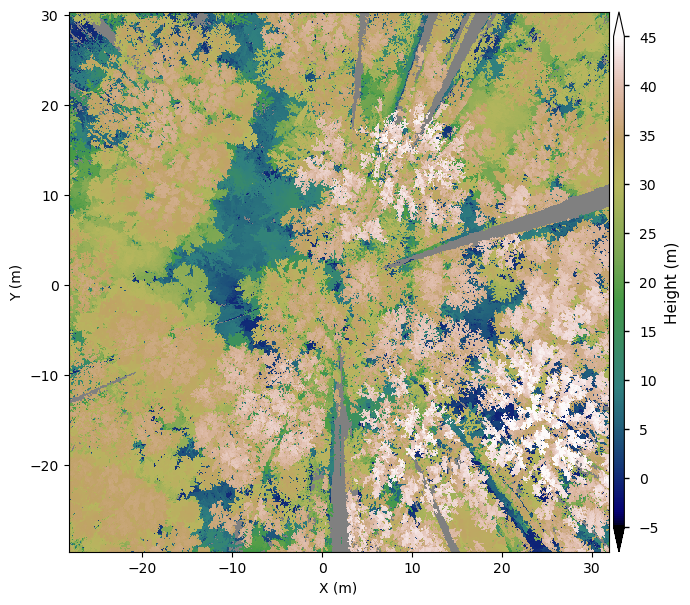

In [11]:
plot_riegl_grid(height_grid, label='Height (m)', clim=[-5,45], figsize=(7,7), extend='both', 
                nbins=None, cmap='gist_earth', xlabel='X (m)', ylabel='Y (m)', facecolor='0.5',
                extent=[x0-grid_extent/2,x0+grid_extent/2,y0-grid_extent/2,y0+grid_extent/2])

## Generate the vertical plant profile

Initialize the vertical plant profiles. $hres$ is the vertical height bin resolution in meters, $zres$ is the zenith angle bin resolution in degrees, and $ares$ is the azimuth angle bin resolution in degrees. Global bounds on the height ($min\_h$, $max\_h$) and zenith angle ($min\_z$, $max\_z$) ranges used for the estimation are also specified here.

In [12]:
# If the ground plane is not defined then set ground_plane to None
# and use the sensor_height argument whe adding scan positions
vpp = plant_profile.Jupp2009(hres=0.5, zres=5, ares=90, 
                             min_z=35, max_z=70, min_h=0, max_h=50,
                             ground_plane=planefit['Parameters'])

Add the upright scan measurements to the vertical plant profile model. We start from 35$\rm ^o$ to avoid incomplete sampling of the 30-35$\rm ^o$ range introduced by scans that are not perfectly levelled. There are different methods used for $P_{gap}$ estimation: WEIGHTED (weighting of returns by 1 / target_count); FIRST (first returns only) and ALL (all returns).

In [13]:
# If using RXP files only as input, set rdbx_file to None (the default)
vpp.add_riegl_scan_position(upright_rxp_fn, upright_transform_fn, sensor_height=None,
    rdbx_file=upright_rdbx_fn, method='WEIGHTED', min_zenith=35, max_zenith=70)

Add the tilt scan measurements to the vertical plant profile model. We only use the tilt scan to fill in upper zenith rings that the upright scan does not observe. We also only start from 5$\rm ^o$ instead of zero to avoid minimize the impact of high spatial variance in $P_{gap}$ on estimation of the mean profile.

In [14]:
# If using RXP files only as input, set rdbx_file to None (the default)
vpp.add_riegl_scan_position(tilt_rxp_fn, tilt_transform_fn, sensor_height=None,
    rdbx_file=tilt_rdbx_fn, method='WEIGHTED', min_zenith=5, max_zenith=35)

### Compute $P_{gap}$ by zenith bin

The default calculation uses all azimuth angle bins. Here we plot the $P_{gap}$($\theta,z$) at the zenith angle resolution specified when intializing the vertical plant profile.

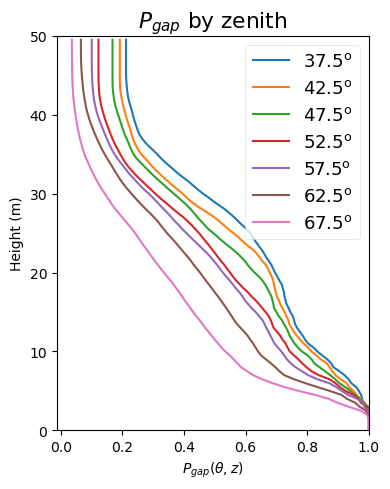

In [15]:
vpp.get_pgap_theta_z()

pgap_labels = [fr'{b:.1f}$\rm ^o$' for b in vpp.zenith_bin]
plot_vertical_profiles(vpp.pgap_theta_z, vpp.height_bin, xlabel=r'$P_{gap}(\theta,z)$',
                      labels=pgap_labels, ylim=[0,50], xlim=[None,1], figsize=[4,5], 
                      title=r'$P_{gap}$ by zenith')

### Compute $P_{gap}$ by azimuth bin

Stratifying $P_{gap}$ estimates for subsets of the azimuth angle range can be useful for investigations into canopy clumping, and excluding or including segments of the scans in the estimation of vertical plant profiles. Note that the azimuth angle resolution specfied when initialing the vertical plant profile determines how narrow a range of azimuth angles can be excluded or included.

You can also use the spherical gridding (see 01_gridding_example.ipynb) to visualize what azimuth segments of the scan to include or exclude.

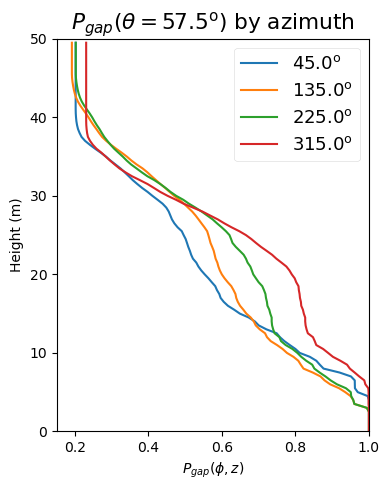

In [16]:
hinge_idx = np.argmin(abs(vpp.azimuth_bin - 57.5))
 
pgap_phi_z = []
for az in range(0, 360, vpp.ares):
    # Set invert to True if min_azimuth and max_azimuth specify the range to exclude
    vpp.get_pgap_theta_z(min_azimuth=az, max_azimuth=az+vpp.ares, invert=False)
    pgap_phi_z.append(vpp.pgap_theta_z[hinge_idx])

pgap_labels = [fr'{b:.1f}$\rm ^o$' for b in vpp.azimuth_bin]
plot_vertical_profiles(pgap_phi_z, vpp.height_bin, xlabel=r'$P_{gap}(\phi,z)$',
                      labels=pgap_labels, ylim=[0,50], xlim=[None,1], figsize=[4,5],
                      title=r'$P_{gap}$($\theta=57.5\rm ^o$) by azimuth')

### Compute vertical plant profiles

There are three methods from Jupp et al. (2009) available for calculation of vertical Plant Area Index (PAI) and Plant Area Volume Density (PAVD) profiles (hinge, linear, and solid angle weighted). We also derive an analytical estimate of the mean element angle from the linear model.

In [17]:
vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)

hinge_pai = vpp.calcHingePlantProfiles()
weighted_pai = vpp.calcSolidAnglePlantProfiles()
linear_pai = vpp.calcLinearPlantProfiles()

hinge_pavd = vpp.get_pavd(hinge_pai)
linear_pavd = vpp.get_pavd(linear_pai)
weighted_pavd = vpp.get_pavd(weighted_pai)

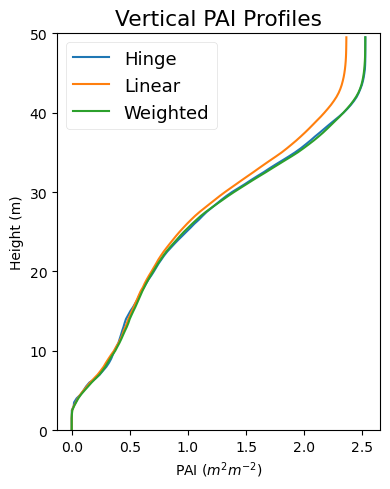

In [18]:
plot_vertical_profiles([hinge_pai,linear_pai,weighted_pai], vpp.height_bin, 
                       labels=['Hinge','Linear','Weighted'], ylim=[0,50], figsize=[4,5],
                       title='Vertical PAI Profiles', xlabel=r'PAI ($m^2 m^{-2}$)')

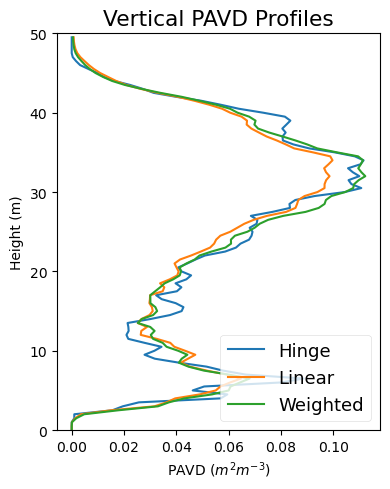

In [19]:
plot_vertical_profiles([hinge_pavd,linear_pavd,weighted_pavd], vpp.height_bin, 
                       labels=['Hinge','Linear','Weighted'], ylim=[0,50], figsize=[4,5],
                       title='Vertical PAVD Profiles')

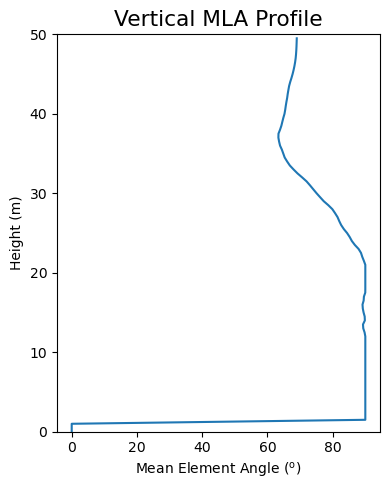

In [20]:
linear_pai,linear_mla = vpp.calcLinearPlantProfiles(calc_mla=True)
plot_vertical_profiles([linear_mla], vpp.height_bin, labels=None, ylim=[0,50], 
                       figsize=[4,5], title='Vertical MLA Profile', 
                       xlabel=r'Mean Element Angle ($\rm ^o$)')